In [1]:
!pip install imbalanced-learn
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, accuracy_score, log_loss, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
df = pd.read_csv('final_dataset.csv')
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,keep_alive_session,device_distinct_emails_8w,month,intended_balcon_missing,bank_months_missing,velocity_6h_missing,income_age_ratio,income_credit_risk_ratio,credit_risk_age_ratio,income_group
0,0,0.3,0.986506,0,25.0,40,0.006735,102.453711,AA,1059,...,1,1.0,0,0,0,0,0.0075,0.001840,4.075,low
1,0,0.8,0.617426,0,89.0,20,0.010095,32.433701,AD,1658,...,1,1.0,0,1,0,0,0.0400,0.005195,7.700,high
2,0,0.8,0.996707,9,14.0,40,0.012316,32.433701,AB,1095,...,0,1.0,0,1,0,0,0.0200,0.008989,2.225,high
3,0,0.6,0.475100,11,14.0,30,0.006991,32.433701,AB,3483,...,1,1.0,0,1,0,0,0.0200,0.006667,3.000,high
4,0,0.9,0.842307,0,29.0,40,5.742626,47.152498,AA,2339,...,0,1.0,0,0,0,0,0.0225,0.009890,2.275,high


In [4]:
df.isnull().sum()

,0
fraud_bool,0
income,0
name_email_similarity,0
prev_address_months_count,0
current_address_months_count,0
customer_age,0
days_since_request,0
intended_balcon_amount,0
payment_type,0
zip_count_4w,0


In [5]:
# check numeric columns for inf values
numeric_cols = df.select_dtypes(include=[np.number])
print("Infs before cleaning:", np.isinf(numeric_cols).sum().sum())

# clean before splitting
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print("Infs after cleaning:", np.isinf(numeric_cols).sum().sum())

Infs before cleaning: 522
Infs after cleaning: 522


In [6]:
categorical_cols = ['payment_type','employment_status','housing_status','source','device_os','income_group']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Checking distribution of fraud

In [7]:
# count the occurrences of each value in the 'fraud' column
fraud_counts = df['fraud_bool'].value_counts()

print("Counts of 0 and 1 in 'fraud' column:")
print(fraud_counts)

Counts of 0 and 1 in 'fraud' column:
fraud_bool
0    983815
1     11006
Name: count, dtype: int64


# Data Preprocessing

# Address class imbalance with undersampling

In [8]:
# train test split
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

objective_col = 'fraud_bool'
X = df.drop(objective_col, axis=1)
y = df[objective_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

In [9]:
X_train_balanced.shape

(15408, 54)

In [10]:
y_train_balanced.shape

(15408,)

In [24]:
y_train_balanced.value_counts()

,count
fraud_bool,
0,7704
1,7704


# Basic Decision Tree (with Random Guess)

In [11]:
model = DecisionTreeClassifier(criterion = 'gini',
                               max_depth=4,
                               min_samples_split=1000,
                               min_samples_leaf=200,
                               class_weight={0:1,1:2}, #small penalty
                               random_state=42)

model.fit(X_train_balanced, y_train_balanced)


DecisionTreeClassifier(class_weight={0: 1, 1: 2}, max_depth=4,
                       min_samples_leaf=200, min_samples_split=1000,
                       random_state=42)

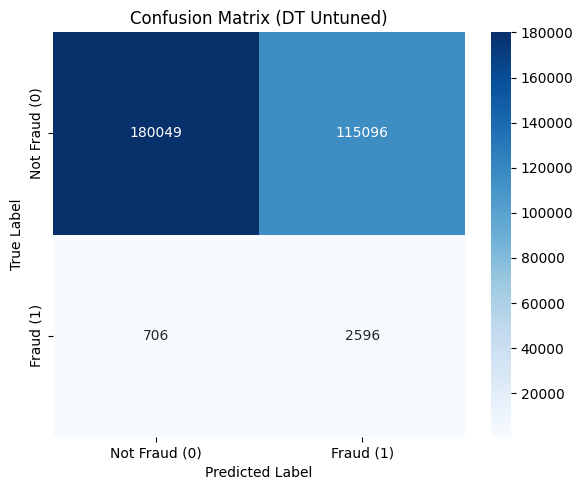

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.61      0.76    295145
           1       0.02      0.79      0.04      3302

    accuracy                           0.61    298447
   macro avg       0.51      0.70      0.40    298447
weighted avg       0.99      0.61      0.75    298447

Decision Tree Classifier (Untuned) AUC score is 0.76559


In [12]:
# evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

# confusion matrix visualisation
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud (0)", "Fraud (1)"],
            yticklabels=["Not Fraud (0)", "Fraud (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (DT Untuned)")
plt.tight_layout()
plt.show()

print("Classification Report:\n", report)
print(f"Decision Tree Classifier (Untuned) AUC score is {roc:.5f}")

# Tuning Parameters

In [13]:
results_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'Best ROC AUC (CV)', 'Best Recall at 1'])

In [14]:
# cross-validation to tune for hyperparameter

# set up stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define hyperparameter grid
param_dist = {
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 2000, 100),
    'min_samples_leaf': np.arange(1, 1000, 100),
    'class_weight': [None, {0: 1, 1: 2}],
    'criterion': ['gini', 'entropy']  # function to measure the quality of a split
}


# randomised Search
random_search_dt = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,  # Try 100 random combinations
    scoring='recall',
    cv=kfold,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# fit the search on balanced training data to find the best model
random_search_dt.fit(X_train_balanced, y_train_balanced)
best_dt = random_search_dt.best_estimator_

dt_best_params = random_search_dt.best_params_
dt_best_roc_auc = random_search_dt.best_score_
dt_best_recall_at_1 = recall_score(y_test, best_dt.predict(X_test))

print("Best parameters (Decision Tree):", dt_best_params)
print("Best ROC AUC score (Decision Tree CV):", dt_best_roc_auc)
print("Best Recall at 1 (Decision Tree CV):", dt_best_recall_at_1)

# append DT results to results_df
results_df = pd.concat([
    results_df,
    pd.DataFrame({
        'Model': ['Decision Tree'],
        'Best Parameters': [dt_best_params],
        'Best ROC AUC (CV)': [dt_best_roc_auc],
        'Best Recall at 1': [dt_best_recall_at_1]
    })
], ignore_index=True)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters (Decision Tree): {'min_samples_split': np.int64(1602), 'min_samples_leaf': np.int64(101), 'max_depth': np.int64(2), 'criterion': 'entropy', 'class_weight': {0: 1, 1: 2}}
Best ROC AUC score (Decision Tree CV): 0.9649531843886159
Best Recall at 1 (Decision Tree CV): 0.9660811629315567


<ipython-input-14-5f7e5f66e33b>:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([


# Evaluation of Base Decision Tree (Tuned)


=== Tuned Decision Tree Evaluation ===
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.22      0.36    295145
           1       0.01      0.97      0.03      3302

    accuracy                           0.23    298447
   macro avg       0.51      0.59      0.19    298447
weighted avg       0.99      0.23      0.36    298447

Confusion Matrix:
 [[ 64653 230492]
 [   112   3190]]
Accuracy: 0.22732009368497588
ROC-AUC Score: 0.7133714814528382


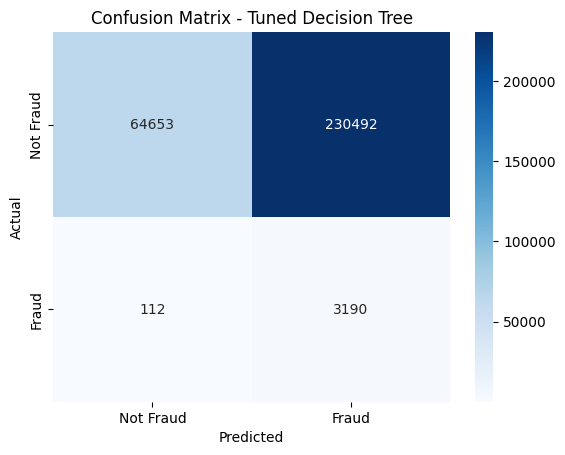

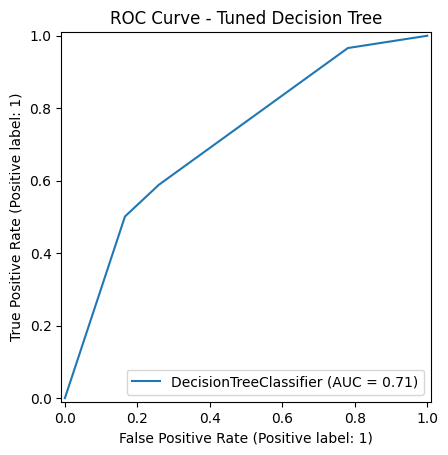

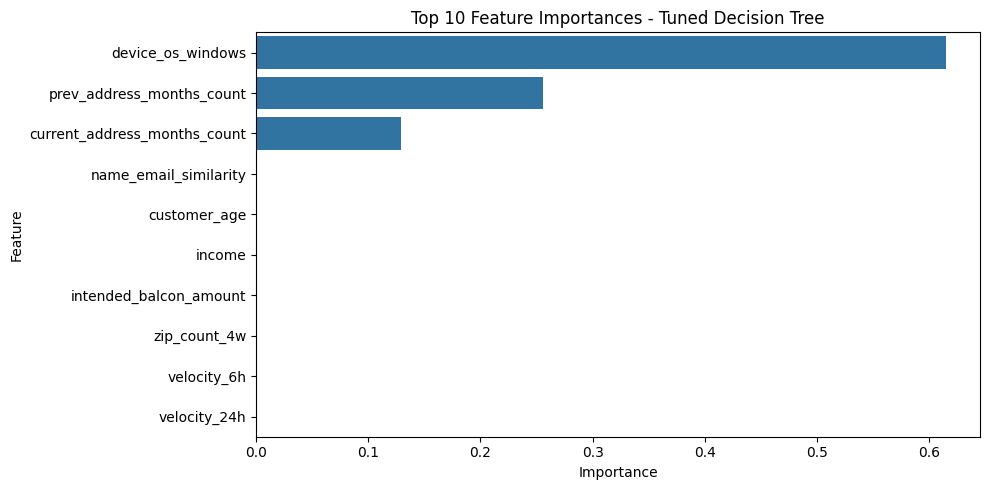

In [15]:
# evaluate best decision tree model on test set
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

print("\n=== Tuned Decision Tree Evaluation ===")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_dt))

# confusion matrix heatmap visualisation
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix - Tuned Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# visualising ROC Curve
RocCurveDisplay.from_estimator(best_dt, X_test, y_test)
plt.title("ROC Curve - Tuned Decision Tree")
plt.show()

# evaluate and visualise feature importance (top 10)
importances_dt = best_dt.feature_importances_
importance_dt_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': importances_dt})
importance_dt_df.sort_values('Importance', ascending=False, inplace=True)

top_n = 10
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_dt_df.head(top_n))
plt.title(f"Top {top_n} Feature Importances - Tuned Decision Tree")
plt.tight_layout()
plt.show()


# Improving with Ensemble Methods: Random Forest Classifier

In [16]:
# define random forest and parameter grid
rf = RandomForestClassifier(random_state=42)
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 10, 50],
    'min_samples_leaf': [1, 5, 10],
    'class_weight': [None, {0: 1, 1: 2}]
}

# apply randomised search
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    scoring='recall',
    cv=kfold,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# fit on balanced training data
random_search_rf.fit(X_train_balanced, y_train_balanced)

best_rf = random_search_rf.best_estimator_
rf_best_params = random_search_rf.best_params_
rf_best_roc_auc = random_search_rf.best_score_
rf_best_recall_at_1 = recall_score(y_test, best_rf.predict(X_test))

print("Best Parameters (Random Forest):", rf_best_params)
print("Best ROC AUC Score (Random Forest CV):", rf_best_roc_auc)
print("Best Recall at 1 (Random Forest CV):", rf_best_recall_at_1)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters (Random Forest): {'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_depth': 5, 'class_weight': {0: 1, 1: 2}}
Best ROC AUC Score (Random Forest CV): 0.9548284551269626
Best Recall at 1 (Random Forest CV): 0.9545729860690491



=== Tuned Random Forest Evaluation ===
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.44      0.61    295145
           1       0.02      0.95      0.04      3302

    accuracy                           0.44    298447
   macro avg       0.51      0.70      0.32    298447
weighted avg       0.99      0.44      0.60    298447

Confusion Matrix:
 [[129077 166068]
 [   150   3152]]
Accuracy: 0.44305689117330715
ROC-AUC Score: 0.8552262493445947


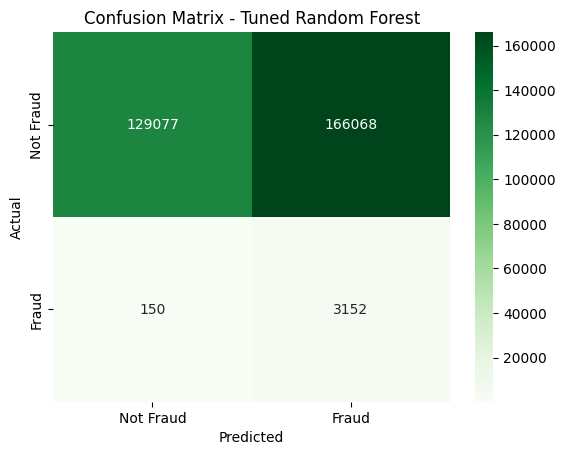

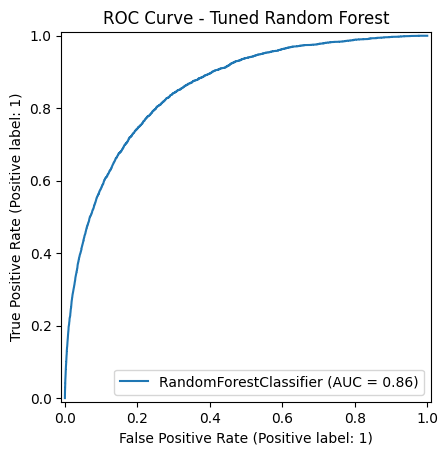

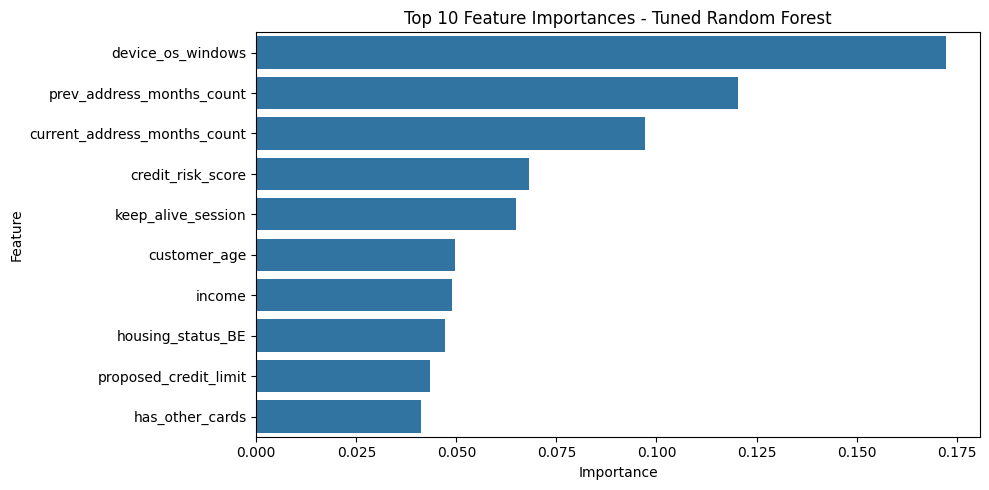

In [17]:
# evaluate best random forest model on test set
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print("\n=== Tuned Random Forest Evaluation ===")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

# confusion matrix heatmap visualisation
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# visualising ROC curve
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve - Tuned Random Forest")
plt.show()

# evaluate and visualise feature importance (Top 10)
importances_rf = best_rf.feature_importances_
importance_rf_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': importances_rf})
importance_rf_df.sort_values('Importance', ascending=False, inplace=True)

top_n = 10
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_rf_df.head(top_n))
plt.title(f"Top {top_n} Feature Importances - Tuned Random Forest")
plt.tight_layout()
plt.show()

# save results to results_df
results_df = pd.concat([
    results_df,
    pd.DataFrame({
        'Model': ['Random Forest'],
        'Best Parameters': [rf_best_params],
        'Best ROC AUC (CV)': [rf_best_roc_auc],
        'Best Recall at 1': [rf_best_recall_at_1]
    })
], ignore_index=True)

# Gradient Boosting

In [18]:

# define Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# 2. define hyperparameter grid
param_dist_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 10, 50],
    'min_samples_leaf': [1, 5, 10]
}

# set up StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# apply randomised search
random_search_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist_gb,
    n_iter=30,
    scoring='recall',
    cv=kfold,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# fit on balanced training data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_balanced)
random_search_gb.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)

best_gb = random_search_gb.best_estimator_
gb_best_params = random_search_gb.best_params_
gb_best_roc_auc = random_search_gb.best_score_
gb_best_recall_at_1 = recall_score(y_test, best_gb.predict(X_test))

print("Best Parameters (Gradient Boosting):", gb_best_params)
print("Best ROC AUC Score (Gradient Boosting CV):", gb_best_roc_auc)
print("Best Recall at 1 (Gradient Boosting CV):", gb_best_recall_at_1)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters (Gradient Boosting): {'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_depth': 5, 'learning_rate': 0.2}
Best ROC AUC Score (Gradient Boosting CV): 0.8084103761261451
Best Recall at 1 (Gradient Boosting CV): 0.8043609933373713



=== Tuned Gradient Boosting Evaluation ===
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89    295145
           1       0.04      0.80      0.08      3302

    accuracy                           0.81    298447
   macro avg       0.52      0.81      0.49    298447
weighted avg       0.99      0.81      0.88    298447

Confusion Matrix:
 [[238057  57088]
 [   646   2656]]
Accuracy: 0.8065519170908068
ROC-AUC Score: 0.8839068681852618


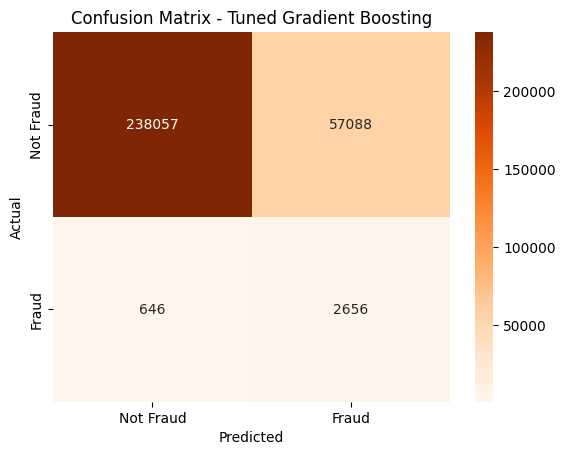

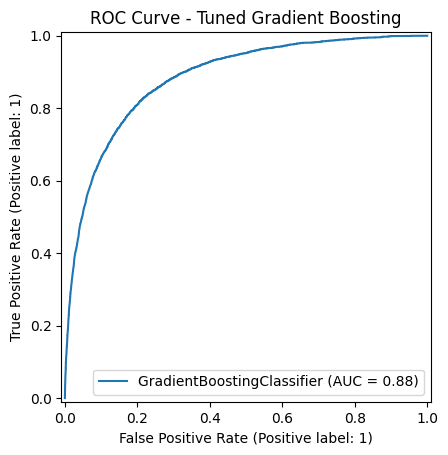

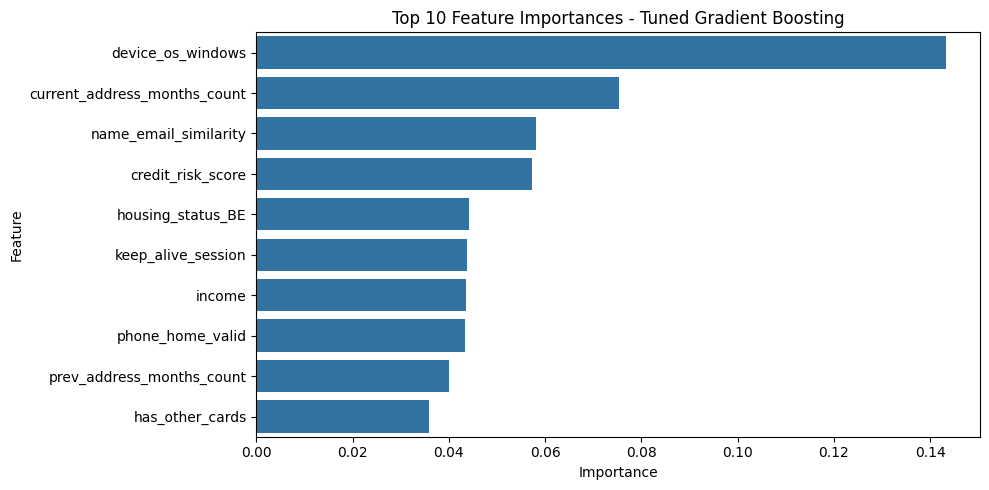

In [19]:
# evaluate the best Gradient Boosting model on test set
y_pred_gb = best_gb.predict(X_test)  # Use X_test (NOT scaled)
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]

print("\n=== Tuned Gradient Boosting Evaluation ===")
print("Classification Report:\n", classification_report(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_gb))

# 9. confusion matrix heatmap visualisation
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix - Tuned Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# visualise ROC curve
RocCurveDisplay.from_estimator(best_gb, X_test, y_test)
plt.title("ROC Curve - Tuned Gradient Boosting")
plt.show()

# evaluate feature importance (Top 10)
importances_gb = best_gb.feature_importances_
importance_gb_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': importances_gb})
importance_gb_df.sort_values('Importance', ascending=False, inplace=True)

top_n = 10
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_gb_df.head(top_n))
plt.title(f"Top {top_n} Feature Importances - Tuned Gradient Boosting")
plt.tight_layout()
plt.show()

results_df = pd.concat([
    results_df,
    pd.DataFrame({
        'Model': ['Gradient Boosting'],
        'Best Parameters': [gb_best_params],
        'Best ROC AUC (CV)': [gb_best_roc_auc],
        'Best Recall at 1': [gb_best_recall_at_1]
    })
], ignore_index=True)

# XGBoost

In [20]:
# define XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='hist', random_state=42)

# define hyperparameter grid
param_dist_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2, 3]
}

# set up stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. apply randomised search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,
    scoring='recall',
    cv=kfold,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# fit on balanced training data
random_search_xgb.fit(X_train_balanced, y_train_balanced)

best_xgb = random_search_xgb.best_estimator_
xgb_best_params = random_search_xgb.best_params_
xgb_best_roc_auc = random_search_xgb.best_score_
xgb_best_recall_at_1 = recall_score(y_test, best_xgb.predict(X_test))

print("Best Parameters (XGBoost):", xgb_best_params)
print("Best ROC AUC Score (XGBoost CV):", xgb_best_roc_auc)
print("Best Recall at 1 (XGBoost CV):", xgb_best_recall_at_1)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:40:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters (XGBoost): {'subsample': 0.8, 'scale_pos_weight': 3, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best ROC AUC Score (XGBoost CV): 0.9875389568251347
Best Recall at 1 (XGBoost CV): 0.9857662023016354



=== Tuned XGBoost Evaluation ===
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.24      0.39    295145
           1       0.01      0.99      0.03      3302

    accuracy                           0.25    298447
   macro avg       0.51      0.61      0.21    298447
weighted avg       0.99      0.25      0.38    298447

Confusion Matrix:
 [[ 70654 224491]
 [    47   3255]]
Accuracy: 0.24764531055765346
ROC-AUC Score: 0.8557701647720526


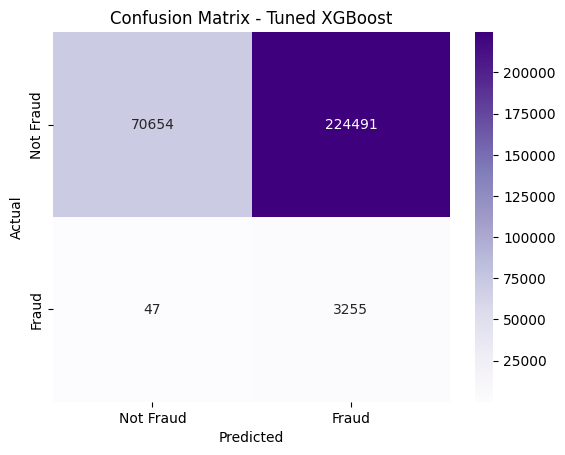

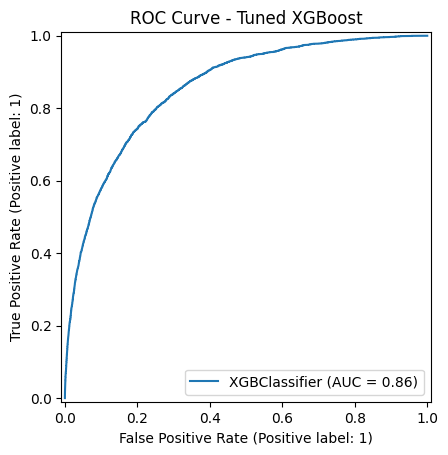

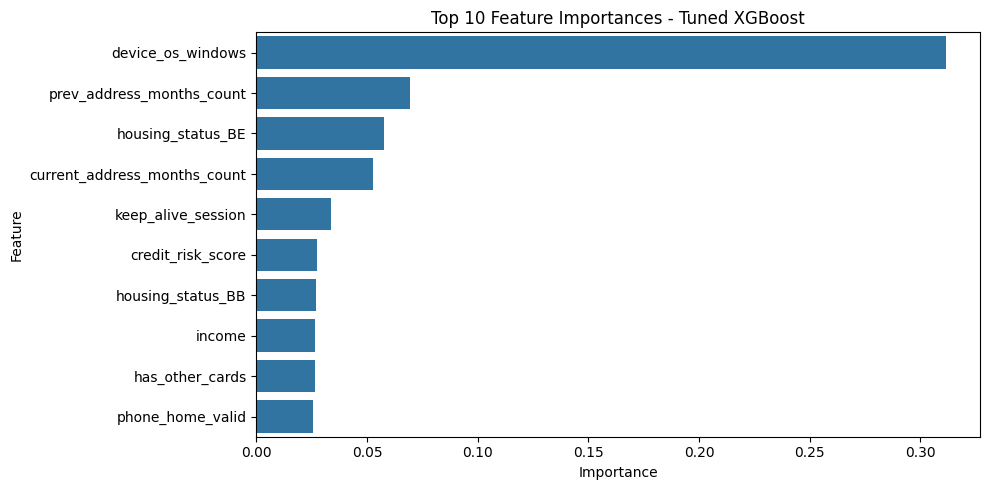

In [21]:
# evaluate best XGBoost Model on test set
y_pred_xgb = best_xgb.predict(X_test)  # X_test (unscaled) — correct
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("\n=== Tuned XGBoost Evaluation ===")
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))

# confusion matrix heatmap visualisation
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Purples",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix - Tuned XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# visualising ROC Curve
RocCurveDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title("ROC Curve - Tuned XGBoost")
plt.show()

# evaluate feature importance (Top 10)
importances_xgb = best_xgb.feature_importances_
importance_xgb_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': importances_xgb})
importance_xgb_df.sort_values('Importance', ascending=False, inplace=True)

top_n = 10
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_xgb_df.head(top_n))
plt.title(f"Top {top_n} Feature Importances - Tuned XGBoost")
plt.tight_layout()
plt.show()

results_df = pd.concat([
    results_df,
    pd.DataFrame({
        'Model': ['XGBoost'],
        'Best Parameters': [xgb_best_params],
        'Best ROC AUC (CV)': [xgb_best_roc_auc],
        'Best Recall at 1': [xgb_best_recall_at_1]
    })
], ignore_index=True)

# Comparing the three improvement methods

In [22]:
# sort results by ROC AUC score
results_df_sorted = results_df.sort_values('Best ROC AUC (CV)', ascending=False)
print(results_df_sorted)

               Model                                    Best Parameters  \
3            XGBoost  {'subsample': 0.8, 'scale_pos_weight': 3, 'n_e...   
0      Decision Tree  {'min_samples_split': 1602, 'min_samples_leaf'...   
1      Random Forest  {'n_estimators': 200, 'min_samples_split': 50,...   
2  Gradient Boosting  {'n_estimators': 200, 'min_samples_split': 50,...   

   Best ROC AUC (CV)  Best Recall at 1  
3           0.987539          0.985766  
0           0.964953          0.966081  
1           0.954828          0.954573  
2           0.808410          0.804361  


In [23]:
# sort results by recall at 1
results_df_sorted = results_df.sort_values('Best Recall at 1', ascending=False)
print(results_df_sorted)

               Model                                    Best Parameters  \
3            XGBoost  {'subsample': 0.8, 'scale_pos_weight': 3, 'n_e...   
0      Decision Tree  {'min_samples_split': 1602, 'min_samples_leaf'...   
1      Random Forest  {'n_estimators': 200, 'min_samples_split': 50,...   
2  Gradient Boosting  {'n_estimators': 200, 'min_samples_split': 50,...   

   Best ROC AUC (CV)  Best Recall at 1  
3           0.987539          0.985766  
0           0.964953          0.966081  
1           0.954828          0.954573  
2           0.808410          0.804361  
